# Docling

Docling simplifies document processing, parsing diverse formats — including advanced PDF understanding — and providing seamless integrations with the gen AI ecosystem.

## References
[Docling: An Efficient Open-Source Toolkit for AI-driven Document Conversion](https://arxiv.org/pdf/2501.17887)  
[Docling Project](https://docling-project.github.io/docling/)

In [1]:
import sys
import os
import time
from pathlib import Path
import rich
from IPython.display import display, Markdown

# Params

In [2]:
path_data = Path() / "data"
path_input = path_data / "raw"
path_output = path_data / "interim" / "docling"  # Store converted

path_output.mkdir(exist_ok=True, parents=True)

In [3]:
IMAGE_RESOLUTION_SCALE = 2.0  # scale=1 correspond of a standard 72 DPI image, also needed to get pages images

## PDF Conversion

In [4]:
path_artifacts = Path.home() / ".cache" / "docling" / "models"  # Docling models are stored here

path_artifacts.exists()

True

In [5]:
from docling.document_converter import DocumentConverter
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions, TableFormerMode
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem


input_file = "Divulgacion-Planetaria-Althera.pdf"  # document per local path or URL
output_file = "Divulgacion-Planetaria-Althera.md"
input_doc_path = path_input / input_file


# Pipeline
pipeline_options = PdfPipelineOptions(
    artifacts_path=path_artifacts.as_posix(),
    )
pipeline_options.do_ocr = True
pipeline_options.do_table_structure = True
pipeline_options.table_structure_options.do_cell_matching = True  # default
pipeline_options.table_structure_options.mode =  TableFormerMode.ACCURATE  # default, also FAST
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True


converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    },
)

# Conversion
tm_start = time.perf_counter()
conv_res = converter.convert(input_doc_path.as_posix())
tm_end = time.perf_counter()
tm_process = tm_end - tm_start
print(f"{tm_process=:0.2f} segs")


# Save pages as images
root_filename_elements = input_doc_path.stem

for page_no, page in conv_res.document.pages.items():
    page_no = page.page_no
    page_image_filename = path_output / f"{root_filename_elements}-{page_no}.png"
    with page_image_filename.open("wb") as fp:
        page.image.pil_image.save(fp, format="PNG")

# Save images of figures and tables (crops)
table_counter = 0
picture_counter = 0
for element, _level in conv_res.document.iterate_items():
    if isinstance(element, TableItem):
        table_counter += 1
        element_image_filename = (
            path_output / f"{root_filename_elements}-table-{table_counter}.png"
        )
        with element_image_filename.open("wb") as fp:
            element.get_image(conv_res.document).save(fp, "PNG")

    if isinstance(element, PictureItem):
        picture_counter += 1
        element_image_filename = (
            path_output / f"{root_filename_elements}-picture-{picture_counter}.png"
        )
        with element_image_filename.open("wb") as fp:
            element.get_image(conv_res.document).save(fp, "PNG")

c:\Users\manuelalberto.romero\Documents\repos\dslabs\mbit\peia-oct25\dslab-docai\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\manuelalberto.romero\Documents\repos\dslabs\mbit\peia-oct25\dslab-docai\.venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
c:\Users\manuelalberto.romero\Documents\repos\dslabs\mbit\peia-oct25\dslab-docai\.venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


tm_process=109.38 segs


`pipeline_options.table_structure_options.do_cell_matching=True` (default)
1. The table structure model infers the table structure
2. Attemps to fill the table structure with the original table cells from the pdf backend
If set to False:
2. Fill the table structure with the predicted cells content. This may improve output quality if you find that multiple columns in extracted tables are erroneously merged into one.

[Control PDF table extraction options](https://docling-project.github.io/docling/usage/#control-pdf-table-extraction-options)


## Conversion Confidence

In [73]:
type(conv_res.confidence)

docling.datamodel.base_models.ConfidenceReport

In [74]:
# Users can and should safely focus on the document-level grade fields — mean_grade and low_grade — to assess overall conversion quality
# https://docling-project.github.io/docling/concepts/confidence_scores/#purpose
print(f"{conv_res.confidence.mean_grade=}")
print(f"{conv_res.confidence.low_grade=}")

conv_res.confidence.mean_grade=<QualityGrade.EXCELLENT: 'excellent'>
conv_res.confidence.low_grade=<QualityGrade.EXCELLENT: 'excellent'>


# Docling Document

Pydantic data structure to set a structured interface to represent the document and its elements (tables, pictures, sections, etc.)

In [75]:
print(f"{type(conv_res)=}")
doc = conv_res.document
print(f"{type(doc)=}")

type(conv_res)=<class 'docling.datamodel.document.ConversionResult'>
type(doc)=<class 'docling_core.types.doc.document.DoclingDocument'>


In [76]:
# Save as json
doc.save_as_json(path_output / "docling-doc-Divulgacion-Planetaria-Althera.json")

### Document Structure

In [77]:
# Content items
# This items contains the actual text (in variables .text and .orig)
print(f"{type(doc.texts)=}")  # section headers, lists, paragraphs, ...
print(f"{type(doc.tables)=}")
print(f"{type(doc.pictures)=}")
print(f"{type(doc.key_value_items)=}")

type(doc.texts)=<class 'list'>
type(doc.tables)=<class 'list'>
type(doc.pictures)=<class 'list'>
type(doc.key_value_items)=<class 'list'>


#### Texts

In [78]:
rich.print(doc.texts[0])
# parent=RefItem(cref='#/body'),
# label=<DocItemLabel.SECTION_HEADER: 'section_header'>, not document title

SectionHeaderItem(
    self_ref='#/texts/0',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=113.88,
                t=690.7010649804688,
                r=487.098,
                b=671.8100649804687,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 37)
        )
    ],
    orig='Un nuevo y fascinante vecino: Althéra',
    text='Un nuevo y fascinante vecino: Althéra',
    formatting=None,
    hyperlink=None,
    level=1
)

In [79]:
rich.print(doc.texts[1])
# parent=RefItem(cref='#/body')
# label=<DocItemLabel.SECTION_HEADER: 'section_header'>
# level=1

SectionHeaderItem(
    self_ref='#/texts/1',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=82.8,
                t=655.4230649804688,
                r=120.13,
                b=644.3720649804687,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 6)
        )
    ],
    orig='Índice',
    text='Índice',
    formatting=None,
    hyperlink=None,
    level=1
)

In [80]:
rich.print(doc.texts[2])
# parent=RefItem(cref='#/groups/0'),
# content_layer=<ContentLayer.BODY: 'body'>,
# label=<DocItemLabel.LIST_ITEM: 'list_item'>, -> Indice (group0)
# enumerated=True,
# marker='1.'  (in list_item)

ListItem(
    self_ref='#/texts/2',
    parent=RefItem(cref='#/groups/0'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.LIST_ITEM: 'list_item'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=94.44,
                t=638.1390649804688,
                r=259.716,
                b=628.5420649804688,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 30)
        )
    ],
    orig='1. Historia del descubrimiento',
    text='Historia del descubrimiento',
    formatting=None,
    hyperlink=None,
    enumerated=True,
    marker='1.'
)

In [81]:
rich.print(doc.texts[12])
# parent=RefItem(cref='#/body'),
# label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
# level=1

SectionHeaderItem(
    self_ref='#/texts/12',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=82.8,
                t=474.70306498046875,
                r=256.322,
                b=463.65206498046877,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 30)
        )
    ],
    orig='1. Historia del descubrimiento',
    text='1. Historia del descubrimiento',
    formatting=None,
    hyperlink=None,
    level=1
)

In [82]:
rich.print(doc.texts[13])
# parent=RefItem(cref='#/body'),
# label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
# level=1 (sections layers are not properly captured)

SectionHeaderItem(
    self_ref='#/texts/13',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=82.8,
                t=448.9700649804688,
                r=320.083,
                b=439.52506498046876,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 48)
        )
    ],
    orig='1.1 Primeras observaciones y sospechas iniciales',
    text='1.1 Primeras observaciones y sospechas iniciales',
    formatting=None,
    hyperlink=None,
    level=1
)

In [83]:
rich.print(doc.texts[14])
# parent=RefItem(cref='#/body'),
# label=<DocItemLabel.TEXT: 'text'>,

TextItem(
    self_ref='#/texts/14',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.TEXT: 'text'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=82.8,
                t=426.2190649804688,
                r=512.804,
                b=320.86206498046886,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 622)
        )
    ],
    orig='El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una 
campaña de observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela 
Estay . La misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, 
pero un patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. 
El análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos 
estrellas en órbita mutua y varios cuerpos orbitando de forma circumbinaria.',
    text='El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una 
campaña de observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela 
Estay . La misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, 
pero un patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. 
El análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos 
estrellas en órbita mutua y varios cuerpos orbitando de forma circumbinaria.',
    formatting=None,
    hyperlink=None
)

In [84]:
rich.print(doc.texts[20])
# Headers
# content_layer=<ContentLayer.FURNITURE: 'furniture'

TextItem(
    self_ref='#/texts/20',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.FURNITURE: 'furniture'>,
    label=<DocItemLabel.PAGE_HEADER: 'page_header'>,
    prov=[
        ProvenanceItem(
            page_no=2,
            bbox=BoundingBox(
                l=82.8,
                t=768.0770649804688,
                r=232.819,
                b=759.2480649804688,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 31)
        )
    ],
    orig='Divulgación Planetaria: 2025-12',
    text='Divulgación Planetaria: 2025-12',
    formatting=None,
    hyperlink=None
)

In [85]:
rich.print(doc.texts[33])
# Footers
# content_layer=<ContentLayer.FURNITURE: 'furniture'

TextItem(
    self_ref='#/texts/33',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.FURNITURE: 'furniture'>,
    label=<DocItemLabel.PAGE_FOOTER: 'page_footer'>,
    prov=[
        ProvenanceItem(
            page_no=2,
            bbox=BoundingBox(
                l=435.96,
                t=104.01906498046878,
                r=502.85,
                b=94.4220649804688,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 13)
        )
    ],
    orig='Página 2 | 18',
    text='Página 2 | 18',
    formatting=None,
    hyperlink=None
)

#### Tables

In [86]:
len(doc.tables)

4

In [87]:
print(doc.tables[0].parent)
print(doc.tables[0].content_layer)

cref='#/body'
ContentLayer.BODY


In [88]:
display(Markdown("# Titulo"))

# Titulo

In [89]:
display(Markdown(
    doc.tables[0].export_to_markdown(doc=doc)
    ))
# check table with no cells
# check double data cell

| Parámetro               | Althéra A   | Althéra B   |
|-------------------------|-------------|-------------|
| Masa                    | 1,28M ☉     | 0,82M ☉     |
| Radio                   | 1,32 R ☉    | 0,74 R ☉    |
| Luminosidad             | 2,4 L ☉     | 0,39 L ☉    |
| Temperatura superficial | 6.350 K     | 4.950 K     |

In [90]:
display(Markdown(doc.tables[1].export_to_markdown(doc=doc)))
# check empty cell
# check double data cell

| Cuerpo                     | Tipo                 | Distancia media (UA)   | Periodo orbital (días terrestres)   |
|----------------------------|----------------------|------------------------|-------------------------------------|
| Thyros I ( HD 4579 Ab )    | Rocoso               | 0,78                   | 215                                 |
| Névalis II ( HD 4579 Ac )  | Rocoso               | 1,36                   | 397                                 |
| Cinturón de Arges          | Asteroides metálicos | 1,65 - 1,85            |                                     |
| Aurelia III ( HD 4579 Ad ) | Rocoso, habitable    | 2,21                   | 589                                 |
| Zephyros IV ( HD 4579 Ae ) | Gigante gaseoso      | 4,92                   | 2.689                               |
| Krion V ( HD 4579 Af )     | Gigante helado       | 8,14                   | 6.873                               |

#### Pictures

In [91]:
# rich.print(doc.pictures[0])
print(doc.pictures[0].parent)
print(doc.pictures[0].content_layer)

cref='#/body'
ContentLayer.BODY


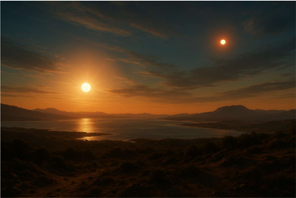

In [92]:
doc.pictures[0].get_image(doc=doc)

In [93]:
doc.pictures[0].footnotes

[]

In [94]:
doc.pictures[0].caption_text(doc=doc)

''

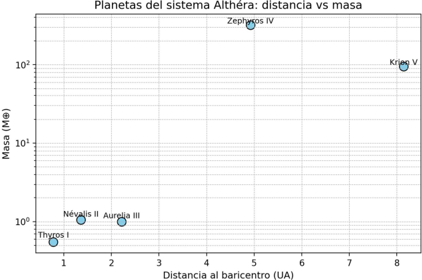

In [95]:
doc.pictures[1].get_image(doc=doc)

In [96]:

print(f"{doc.pictures[1].caption_text(doc=doc)=}")
print(f"{doc.pictures[1].footnotes=}")

doc.pictures[1].caption_text(doc=doc)=''
doc.pictures[1].footnotes=[]


Figure 3 Notas de Mariela Estay el día del descubrimiento


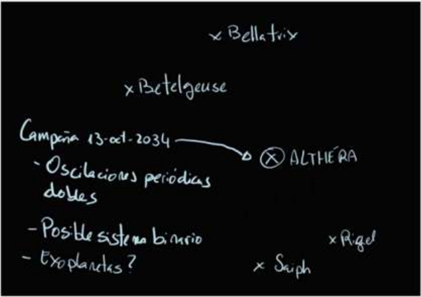

In [97]:
print(doc.pictures[2].caption_text(doc=doc))
doc.pictures[2].get_image(doc=doc)

In [98]:
doc.pictures[2].get_annotations()

[]

In [99]:
doc.pictures[2].children

[RefItem(cref='#/texts/230'),
 RefItem(cref='#/texts/231'),
 RefItem(cref='#/texts/232'),
 RefItem(cref='#/texts/233'),
 RefItem(cref='#/texts/234')]

In [100]:
doc.pictures[2].captions

[RefItem(cref='#/texts/230')]

In [101]:
doc.pictures[2].footnotes

[]

In [102]:
# rich.print(doc.pictures[2]) # uncomment this line, (carefull base64 field)
# children=[RefItem(cref='#/texts/230'), RefItem(cref='#/texts/231'), RefItem(cref='#/texts/233'), RefItem(cref='#/texts/234')],
# captions=[RefItem(cref='#/texts/228')],
# annotations=[]
# references=[],
# footnotes=[],

In [103]:
for i, el in enumerate(doc.pictures[2].children):
    element_id = int(el.cref.split("/")[-1])  # '#/texts/230' -> 230
    print(f"Element {i} | {element_id=}")
    print("Extracted text: ", doc.texts[element_id].orig)

Element 0 | element_id=230
Extracted text:  Figure 3 Notas de Mariela Estay el día del descubrimiento
Element 1 | element_id=231
Extracted text:  2034
Element 2 | element_id=232
Extracted text:  Perodas
Element 3 | element_id=233
Extracted text:  sst
Element 4 | element_id=234
Extracted text:  Osclcovs


#### Key Value Items

In [104]:
doc.key_value_items

[]

### Document Structure

In [105]:
# Content structure items

print(f"{type(doc.body)=}")  # all elements: texts, pictures, tables and groups
print(f"{type(doc.furniture)=}")  # elements outside body
print(f"{type(doc.groups)=}")  # pieces of text like lists and so on

type(doc.body)=<class 'docling_core.types.doc.document.GroupItem'>
type(doc.furniture)=<class 'docling_core.types.doc.document.GroupItem'>
type(doc.groups)=<class 'list'>


C:\Users\manuelalberto.romero\AppData\Local\Temp\ipykernel_18436\1248164015.py:4: DeprecationWarning: deprecated
  print(f"{type(doc.furniture)=}")  # elements outside body


In [106]:
doc.body.children[:10]

[RefItem(cref='#/texts/0'),
 RefItem(cref='#/texts/1'),
 RefItem(cref='#/groups/0'),
 RefItem(cref='#/texts/12'),
 RefItem(cref='#/texts/13'),
 RefItem(cref='#/texts/14'),
 RefItem(cref='#/texts/15'),
 RefItem(cref='#/texts/16'),
 RefItem(cref='#/groups/1'),
 RefItem(cref='#/texts/20')]

In [107]:
doc.groups[:6]
# #/groups/0': index
# #/groups/1

[ListGroup(self_ref='#/groups/0', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/2'), RefItem(cref='#/texts/3'), RefItem(cref='#/texts/4'), RefItem(cref='#/texts/5'), RefItem(cref='#/texts/6'), RefItem(cref='#/texts/7'), RefItem(cref='#/texts/8'), RefItem(cref='#/texts/9'), RefItem(cref='#/texts/10'), RefItem(cref='#/texts/11')], content_layer=<ContentLayer.BODY: 'body'>, name='list', label=<GroupLabel.LIST: 'list'>),
 ListGroup(self_ref='#/groups/1', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/17'), RefItem(cref='#/texts/18'), RefItem(cref='#/texts/19')], content_layer=<ContentLayer.BODY: 'body'>, name='list', label=<GroupLabel.LIST: 'list'>),
 ListGroup(self_ref='#/groups/2', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/26'), RefItem(cref='#/texts/27'), RefItem(cref='#/texts/28')], content_layer=<ContentLayer.BODY: 'body'>, name='list', label=<GroupLabel.LIST: 'list'>),
 ListGroup(self_ref='#/groups/3', parent=RefItem(cref='#/body'

In [108]:
# index (list)
print(doc.texts[2].orig)
print(doc.texts[3].orig)
print(doc.texts[4].orig)

1. Historia del descubrimiento
2. Conoce a Althéra
3. Los soles de Althéra


In [109]:
# group 0 inspection
rich.print(doc.groups[0])

for el_child in doc.groups[0].children:
    el_child_ref = el_child.cref.split("/")  # #/texts/N
    el_child_kind = el_child_ref[1]
    el_child_id = int(el_child_ref[2])
    if el_child_kind == "texts":
        el_child_id_text = doc.texts[el_child_id].orig
        print(f"{el_child_id=}: {el_child_id_text} ")

ListGroup(
    self_ref='#/groups/0',
    parent=RefItem(cref='#/body'),
    children=[
        RefItem(cref='#/texts/2'),
        RefItem(cref='#/texts/3'),
        RefItem(cref='#/texts/4'),
        RefItem(cref='#/texts/5'),
        RefItem(cref='#/texts/6'),
        RefItem(cref='#/texts/7'),
        RefItem(cref='#/texts/8'),
        RefItem(cref='#/texts/9'),
        RefItem(cref='#/texts/10'),
        RefItem(cref='#/texts/11')
    ],
    content_layer=<ContentLayer.BODY: 'body'>,
    name='list',
    label=<GroupLabel.LIST: 'list'>
)

el_child_id=2: 1. Historia del descubrimiento 
el_child_id=3: 2. Conoce a Althéra 
el_child_id=4: 3. Los soles de Althéra 
el_child_id=5: 4. Estructura general de Althéra 
el_child_id=6: 5. Planetas interiores 
el_child_id=7: 6. Planetas exteriores 
el_child_id=8: 7. Lunas y satélites menores 
el_child_id=9: 8. Fenómenos destacados 
el_child_id=10: 9. Habitabilidad y astrobiología 
el_child_id=11: 10. Conclusiones y perspectivas futuras 


In [110]:
def display_group(idx):  # doc not added as arg
    rich.print(doc.groups[idx])

    for el_child in doc.groups[idx].children:
        el_child_ref = el_child.cref.split("/")  # #/texts/N
        el_child_kind = el_child_ref[1]
        el_child_id = int(el_child_ref[2])
        if el_child_kind == "texts":
            el_child_id_text = doc.texts[el_child_id].orig
            print(f"{el_child_id=}: {el_child_id_text} ")

display_group(1)

ListGroup(
    self_ref='#/groups/1',
    parent=RefItem(cref='#/body'),
    children=[RefItem(cref='#/texts/17'), RefItem(cref='#/texts/18'), RefItem(cref='#/texts/19')],
    content_layer=<ContentLayer.BODY: 'body'>,
    name='list',
    label=<GroupLabel.LIST: 'list'>
)

el_child_id=17: · ELT (Extremely Large Telescope) en el Desierto de Atacama para espectroscopía de alta resolución. 
el_child_id=18: · Telescopio Espacial Nancy Grace Roman para fotometría de gran precisión en tránsitos. 
el_child_id=19: · Interferometría de radio desde la red Very Long Baseline Array (VLBA) para afinar la distancia y parámetros orbitales del sistema. 


In [111]:
display_group(2)

ListGroup(
    self_ref='#/groups/2',
    parent=RefItem(cref='#/body'),
    children=[RefItem(cref='#/texts/26'), RefItem(cref='#/texts/27'), RefItem(cref='#/texts/28')],
    content_layer=<ContentLayer.BODY: 'body'>,
    name='list',
    label=<GroupLabel.LIST: 'list'>
)

el_child_id=26: 1. Dinámica circumbinaria estable - demostró que los planetas pueden mantener órbitas estables y climas equilibrados alrededor de dos soles, desafiando modelos anteriores. 
el_child_id=27: 2. Química atmosférica compleja - Aurelia III presenta una mezcla de gases que, en equilibrio fotoquímico, sugieren procesos biológicos o geoquímicos activos. 
el_child_id=28: 3. Proximidad relativa - su cercanía permite observaciones directas en la próxima década con telescopios como el Habitable Worlds Observatory (HWO) y misiones de espectrometría directa de superficie como Starshot Spectra . 


In [112]:
display_group(3)

ListGroup(
    self_ref='#/groups/3',
    parent=RefItem(cref='#/body'),
    children=[RefItem(cref='#/texts/37'), RefItem(cref='#/texts/38')],
    content_layer=<ContentLayer.BODY: 'body'>,
    name='list',
    label=<GroupLabel.LIST: 'list'>
)

el_child_id=37: · Althéra A ( HD 4579 A ), una enana amarilla-blanca de tipo F7V, más masiva y luminosa que el Sol. 
el_child_id=38: · Althéra B ( HD 4579 B ), una enana naranja de tipo K2V, algo más fría y longeva. 


In [113]:
# truncated list by page 
display_group(4)

ListGroup(
    self_ref='#/groups/4',
    parent=RefItem(cref='#/body'),
    children=[RefItem(cref='#/texts/44'), RefItem(cref='#/texts/45'), RefItem(cref='#/texts/46')],
    content_layer=<ContentLayer.BODY: 'body'>,
    name='list',
    label=<GroupLabel.LIST: 'list'>
)

el_child_id=44: · Luminiscencia variable combinada: las diferencias de color y brillo entre Althéra A y B generan amaneceres y atardeceres dobles de tonalidades doradas y anaranjadas. 
el_child_id=45: · Influencia gravitacional múltiple: la presencia de dos gigantes gaseosos exteriores, Zephyros IV y Krion V, ayuda a limpiar el espacio interior de objetos errantes, protegiendo a los planetas habitables de impactos masivos frecuentes. 
el_child_id=46: · Cinturón de Arges activo: región rica en asteroides metálicos, con colisiones frecuentes que producen brillantes lluvias de meteoros observables desde Aurelia III. 


In [114]:
# truncated list by page continuation
display_group(5)

ListGroup(
    self_ref='#/groups/5',
    parent=RefItem(cref='#/body'),
    children=[RefItem(cref='#/texts/53'), RefItem(cref='#/texts/54')],
    content_layer=<ContentLayer.BODY: 'body'>,
    name='list',
    label=<GroupLabel.LIST: 'list'>
)

el_child_id=53: · Althéra A ( HD 4579 A ): estrella de tipo F7V , más caliente y luminosa que el Sol, con un tono blanco-dorado. 
el_child_id=54: · Althéra B ( HD 4579 B ): estrella de tipo K2V , más fría y longeva, de tonalidad naranja intensa. 


In [115]:
# rich.print(doc.body )  # root of the document layout  (long list)

In [116]:
type(doc)

docling_core.types.doc.document.DoclingDocument

## Export document to Markdown

In [117]:
# Remove headers
HEADERS = "Divulgación Planetaria: 2025-12"

lst_el_headers = []
for el in doc.texts:
    if el.orig == HEADERS:
        lst_el_headers.append(el)

n_headers = len(lst_el_headers)
print(f"{n_headers=}")
if len(lst_el_headers) <= 16:  # expected maximum number of headers
    doc.delete_items(node_items=lst_el_headers)


n_headers=16


In [118]:
# Try to reprocess handwritten images

filename_img3 = path_output / "Divulgacion Planetaria Althera-picture-3.png"

img_converter = (
        DocumentConverter(  # all of the below is optional, has internal defaults.
            allowed_formats=[
                InputFormat.IMAGE,
            ],  # whitelist formats, non-matching files are ignored.
        )
    )

tm_start = time.perf_counter()
conv_res_img3 = img_converter.convert(filename_img3.as_posix())
tm_end = time.perf_counter()
tm_process = tm_end - tm_start
print(f"{tm_process=:0.2f} segs")

for i, el_text in enumerate(conv_res_img3.document.texts):
    print(f"{el_text.text=}")
# Results with Tesseract may improve


c:\Users\manuelalberto.romero\Documents\repos\dslabs\mbit\peia-oct25\dslab-docai\.venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


tm_process=10.80 segs
el_text.text='Gamp~'
el_text.text='Osclcovs'
el_text.text='Pos'


In [119]:
 # Export to markdown
res_md = doc.export_to_markdown()          
display(Markdown(res_md[:2000]))

## Un nuevo y fascinante vecino: Althéra

## Índice

1. Historia del descubrimiento
2. Conoce a Althéra
3. Los soles de Althéra
4. Estructura general de Althéra
5. Planetas interiores
6. Planetas exteriores
7. Lunas y satélites menores
8. Fenómenos destacados
9. Habitabilidad y astrobiología
10. Conclusiones y perspectivas futuras

## 1. Historia del descubrimiento

## 1.1 Primeras observaciones y sospechas iniciales

El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una campaña de observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela Estay . La misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, pero un patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. El análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos estrellas en órbita mutua y varios cuerpos orbitando de forma circumbinaria.

## 1.2 Confirmación mediante técnicas combinadas

En los meses siguientes, un consorcio internacional liderado por la Agencia Espacial Europea (ESA) y el Instituto Max Planck de Astronomía desplegó observaciones complementarias utilizando:

- ELT (Extremely Large Telescope) en el Desierto de Atacama para espectroscopía de alta resolución.
- Telescopio Espacial Nancy Grace Roman para fotometría de gran precisión en tránsitos.
- Interferometría de radio desde la red Very Long Baseline Array (VLBA) para afinar la distancia y parámetros orbitales del sistema.

Fue el equipo del astrónomo estadounidense Dr. Jonathan Kepler-Saunders quien confirmó, mediante el método de velocidad radial ultraestable, la existencia de cinco planetas principales y varios cinturones de escombros.

## 1.3 Descubrimiento revolucionario de la zona habitable circumbinaria

El hallazgo más impactante llegó en 2034, cuando la misión LUVOIR-B (Large UV/Optical/IR Surveyor)

In [120]:
# Save markdown with references to images
doc.save_as_markdown(
    (path_output / "Divulgacion-Planetaria-Althera-wimgtb.md").as_posix(),   # creates a folder for artifacts
    image_mode=ImageRefMode.REFERENCED 
    )

# Save markdown with no references to images
doc.save_as_markdown(
    (path_output / output_file).as_posix(),
    image_mode=ImageRefMode.PLACEHOLDER  
    )


# Miscellanea

## Formulas

In [121]:
doc.texts[206].orig

'𝑎\u0bd6\u0be5\u0bdc௧ =  𝑎 \u0bd5 [ 1.60 + 5.10 𝑒 \u0bd5 -2.22 𝑒 \u0bd5 ଶ +4.12 𝜇 - 4.27 𝑒\u0bd5  𝜇 - 5.09 𝜇 ଶ +4.61 𝑒 \u0bd5 ଶ 𝜇 ଶ ]'

In [122]:
display(Markdown(doc.texts[206].orig)) 

𝑎௖௥௜௧ =  𝑎 ௕ [ 1.60 + 5.10 𝑒 ௕ -2.22 𝑒 ௕ ଶ +4.12 𝜇 - 4.27 𝑒௕  𝜇 - 5.09 𝜇 ଶ +4.61 𝑒 ௕ ଶ 𝜇 ଶ ]

In [123]:
display(Markdown(res_md[-5000:]))  # locate formulas

héra, resulta relevante considerar el límite teórico de estabilidad circumbinaria definido por Holman &amp; Wiegert (1999). Esta formulación permite calcular la distancia mínima a la que un planeta puede mantener una órbita estable alrededor de dos estrellas, en función de la separación, la excentricidad del binario y la relación de masas estelares. Aplicado a Althéra, el valor obtenido es de aproximadamente 1,19 UA , lo que implica que cualquier órbita interior a esa distancia sufriría perturbaciones gravitatorias capaces de desestabilizarla a largo plazo. Sin embargo, al incorporar factores adicionales como resonancias con los gigantes exteriores, excentricidades planetarias y variaciones inducidas por la actividad estelar, el margen práctico de seguridad se sitúa en torno a 1,8 UA . Esta cifra explica por qué no se observan planetas estables más cerca del centro binario y por qué Aurelia III , ubicada en el corazón de la zona habitable, disfruta de condiciones dinámicamente estables.

## Límite interior teórico de estabilidad para órbitas circumbinarias:

𝑎௖௥௜௧ =  𝑎 ௕ [ 1.60 + 5.10 𝑒 ௕ -2.22 𝑒 ௕ ଶ +4.12 𝜇 - 4.27 𝑒௕  𝜇 - 5.09 𝜇 ଶ +4.61 𝑒 ௕ ଶ 𝜇 ଶ ]

## Parámetros de Althéra:

- Separación media del binario: 𝑎௕ = 0,42 𝑈𝐴
- Excentricidad del binario: 𝑒௕ = 0,12
- Masas estelares: 𝑀஺ = 1,28 𝑀⊙ , 𝑀஻ = 0,82 𝑀⊙
- Relación de masas: 𝜇 = ெಳ ெಲାெಳ = ଴,଼ଶ ଵ,ଶ଼ା଴,଼ଶ ≈ 0,3905

## Sustituyendo:

𝑓𝑎𝑐𝑡𝑜𝑟 ≈  2,8228  ⇒ 𝑎௖௥௜௧  =  0,42 × 2,8228  ≈  1,186 𝑈𝐴

Interpretación: 𝑎௖௥௜௧ indica el límite interior teórico por debajo del cual las órbitas circumbinarias tienden a ser inestables. En la práctica, y considerando resonancias con los gigantes exteriores, excentricidades planetarias y actividad estelar , adoptamos un margen conservador ≈ 1,8 UA como borde operativo de estabilidad. Este valor es coherente con la arquitectura descrita y con la ubicación de Aurelia III en pleno dominio estable.

## Anexo: Miscelánea

Figure 3 Notas de Mariela Estay el día del descubrimiento

<!-- image -->

## Anexo: Listado de cuerpos menores

| Nombre           | Tamaño   | Descripción                                                                                                         |
|------------------|----------|---------------------------------------------------------------------------------------------------------------------|
| Arges-1 'Pyron'  | 320km    | Asteroide metálico (tipo M) con alto contenido en hierro-níquel; órbita estable en el centro del Cinturón de Arges. |
| Arges-2 'Lythos' | 210km    | Asteroide rocoso (tipo S), superficie muy fracturada por impactos antiguos.                                         |
| Arges-3 'Calyx'  | 95km     | Asteroide carbonáceo oscuro (tipo C) con albedo extremadamente bajo.                                                |
| Arges-4 'Virel'  | 180km    | Asteroide mixto roca-hielo, probable remanente de un protoplaneta fallido.                                          |
| Arges-5 'Thal'   | 60km     | Asteroide alargado con rotación rápida; posible binario de contacto.                                                |
| Arges-6 'Mordax' | 140km    | Asteroide metálico brillante, detectable desde Aurelia III por reflexión solar.                                     |
| Arges-7 'Nysa'   | 72km     | Asteroide rico en silicatos claros; alto albedo relativo.                                                           |
| Arges-8 'Kelmon' | 55km     | Asteroide orgánico con compuestos volátiles congelados en el subsuelo.                                              |
| Arges-9 'Orveth' | 410km    | El mayor objeto del cinturón; posible planeta enano con forma casi esférica.                                        |

| Nombre            | Tamaño   | Descripción                                                               |
|-------------------|----------|---------------------------------------------------------------------------|
| Arges-10 'Silpha' | 88km     | Asteroide con superficie estriada por fuerzas de marea pasadas.           |
| Arges-11 'Rhyx'   | 34km     | Asteroide irregular con órbita ligeramente excéntrica.                    |
| Arges-12 'Eron'   | 120km    | Asteroide tipo S con vetas metálicas expuestas.                           |
| Arges-13 'Kyris'  | 67km     | Asteroide binario; dos lóbulos unidos por un cuello estrecho.             |
| Arges-14 'Damar'  | 200km    | Asteroide diferenciado con núcleo metálico parcial.                       |
| Arges-15 'Ulren'  | 48km     | Asteroide poroso, probable pila de escombros.                             |
| Arges-16 'Phor'   | 160km    | Asteroide oscuro con fuerte absorción en infrarrojo.                      |
| Arges-17 'Nyxel'  | 92km     | Asteroide rico en carbono con trazas de aminoácidos simples.              |
| Arges-18 'Vaelor' | 130km    | Asteroide rocoso con inclinación orbital elevada.                         |
| Arges-19 'Ithra'  | 58km     | Asteroide con rotación caótica, probablemente tras una colisión reciente. |

# Resultados:
* Muy buena identificación de secciones, pero no del nivel (extraer del texto capturado en orig)
* Buen parsing de tablas
* La representación del documento permite alta flexibilidad
* El OCR de base (EasyOCR) no obtiene el contenido como texto de las imágenes manuscritas
* Problemas para reconocer fórmulas complejas


## Chunking

#### Hierarchical

Attemps to merge some elements from the document body.

In [7]:
from docling.chunking import HybridChunker, HierarchicalChunker
import tiktoken
import pandas as pd
from docling_core.transforms.chunker.tokenizer.openai import OpenAITokenizer

tokenizer = OpenAITokenizer(
    tokenizer=tiktoken.encoding_for_model("gpt-4o"),
    max_tokens=2048,  # context window length required for OpenAI tokenizers
)

chunker = HierarchicalChunker(
    merge_list_items=True,
    
)
chunk_iter = chunker.chunk(dl_doc=doc)
lst_chunks = list(chunk_iter)
lst_chunk_sizes = [tokenizer.count_tokens(x.text) for x in lst_chunks]
se_chunk_analisis = pd.Series(lst_chunk_sizes).describe()

print("Hierarchical Chunking analysis:")
se_chunk_analisis

NameError: name 'doc' is not defined

In [8]:
rich.print(lst_chunks[0].text)


NameError: name 'lst_chunks' is not defined

In [126]:
rich.print(lst_chunks[1].text)


El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una campaña de 
observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela Estay . La 
misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, pero un 
patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. El 
análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos estrellas 
en órbita mutua y varios cuerpos orbitando de forma circumbinaria.

In [127]:
# Contextualize: Add some metadata and references
rich.print(
    chunker.contextualize(chunk=lst_chunks[1])
    )


1.1 Primeras observaciones y sospechas iniciales
El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una campaña de 
observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela Estay . La 
misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, pero un 
patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. El 
análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos estrellas 
en órbita mutua y varios cuerpos orbitando de forma circumbinaria.

In [128]:
# Contextualize: Add some metadata and references
rich.print(
    chunker.contextualize(chunk=lst_chunks[25])
    )
# Table?
rich.print(
    chunker.contextualize(chunk=lst_chunks[26])
    )

3.2 Masas, radios y luminosidades comparadas
La diferencia de luminosidad significa que, aunque Althéra A domina el aporte energético, Althéra B contribuye de 
manera significativa a la estabilidad térmica del sistema, suavizando las variaciones extremas en la zona 
habitable.

3.3 Ciclo de vida y edad estimada del sistema binario
Estudios de metalicidad realizados con el ELT indican que ambas estrellas tienen composiciones químicas similares, 
con una proporción de elementos pesados algo mayor que la del Sol ([Fe/H] ≈ +0,08). Esto sugiere que se formaron a 
partir de la misma nube molecular hace aproximadamente 4.900 millones de años , una edad comparable a la del 
Sistema Solar.

#### HybridChunker

It starts from the result of the hierarchical chunker and, based on the user-provided tokenizer (typically to be aligned to the embedding model tokenizer), it:
* does one pass where it splits chunks only when needed (i.e. oversized w.r.t. tokens), &
* another pass where it merges chunks only when possible (i.e. undersized successive chunks with same headings & captions) — users can opt out of this step via param merge_peers (by default True)


(Recommended option)

In [129]:
chunker_hybrid = HybridChunker(
    tokenizer=tokenizer,
    merge_list_items=True,
    merge_peers=True,
)

chunk_iter = chunker_hybrid.chunk(dl_doc=doc)
lst_chunks_hybrid = list(chunk_iter)
lst_chunk_sizes_hybrid  = [tokenizer.count_tokens(x.text) for x in lst_chunks_hybrid ]
se_chunk_analisis_hybrid  = pd.Series(lst_chunk_sizes_hybrid ).describe()

print("Hybrid Chunking analysis:")
se_chunk_analisis_hybrid 

Hybrid Chunking analysis:


count     43.000000
mean     186.883721
std      143.910887
min       15.000000
25%      108.500000
50%      145.000000
75%      207.500000
max      819.000000
dtype: float64

In [130]:
rich.print(lst_chunks_hybrid[0].text)

1. Historia del descubrimiento
2. Conoce a Althéra
3. Los soles de Althéra
4. Estructura general de Althéra
5. Planetas interiores
6. Planetas exteriores
7. Lunas y satélites menores
8. Fenómenos destacados
9. Habitabilidad y astrobiología
10. Conclusiones y perspectivas futuras

In [131]:
rich.print(lst_chunks_hybrid[1].text)

El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una campaña de 
observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela Estay . La 
misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, pero un 
patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. El 
análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos estrellas 
en órbita mutua y varios cuerpos orbitando de forma circumbinaria.

In [132]:
rich.print(lst_chunks_hybrid[2].text)

En los meses siguientes, un consorcio internacional liderado por la Agencia Espacial Europea (ESA) y el Instituto 
Max Planck de Astronomía desplegó observaciones complementarias utilizando:
- ELT (Extremely Large Telescope) en el Desierto de Atacama para espectroscopía de alta resolución.
- Telescopio Espacial Nancy Grace Roman para fotometría de gran precisión en tránsitos.
- Interferometría de radio desde la red Very Long Baseline Array (VLBA) para afinar la distancia y parámetros 
orbitales del sistema.
Fue el equipo del astrónomo estadounidense Dr. Jonathan Kepler-Saunders quien confirmó, mediante el método de 
velocidad radial ultraestable, la existencia de cinco planetas principales y varios cinturones de escombros.

In [133]:
rich.print(
    chunker.contextualize(chunk=lst_chunks_hybrid[9])
    )
print("-"*30)
rich.print(
    chunker.contextualize(chunk=lst_chunks_hybrid[10])
    )
print("-"*30)
rich.print(
    chunker.contextualize(chunk=lst_chunks_hybrid[11])
    )

3.2 Masas, radios y luminosidades comparadas
El sistema binario Althéra está formado por dos estrellas de características bien contrastadas:
Althéra A , más masiva y luminosa, con 1,28 masas solares, un radio de 1,32 radios solares y una temperatura 
superficial de 6.350 K, y Althéra B , más pequeña y fría, con 0,82 masas solares, 0,74 radios solares y 4.950 K. 
Aunque la luminosidad de Althéra A (2,4 veces la del Sol)
domina el aporte energético global, la presencia de Althéra B, con una luminosidad de 0,39 L ☉ , actúa como un 
regulador térmico que suaviza las variaciones extremas de temperatura en la zona habitable, contribuyendo a su 
estabilidad a largo plazo.
Masa, Althéra A = 1,28M ☉. Masa, Althéra B = 0,82M ☉. Radio, Althéra A = 1,32 R ☉. Radio, Althéra B = 0,74 R ☉. 
Luminosidad, Althéra A = 2,4 L ☉. Luminosidad, Althéra B = 0,39 L ☉. Temperatura superficial, Althéra A = 6.350 K. 
Temperatura superficial, Althéra B = 4.950 K
La diferencia de luminosidad significa que, aunque Althéra A domina el aporte energético, Althéra B contribuye de 
manera significativa a la estabilidad térmica del sistema, suavizando las variaciones extremas en la zona 
habitable.

------------------------------


3.3 Ciclo de vida y edad estimada del sistema binario
Estudios de metalicidad realizados con el ELT indican que ambas estrellas tienen composiciones químicas similares, 
con una proporción de elementos pesados algo mayor que la del Sol ([Fe/H] ≈ +0,08). Esto sugiere que se formaron a 
partir de la misma nube molecular hace aproximadamente 4.900 millones de años , una edad comparable a la del 
Sistema Solar.
Althéra A, al ser más masiva, evolucionará hacia gigante roja en unos 4.000 millones de años, mientras que Althéra 
B permanecerá estable durante varios miles de millones más. Esta diferencia temporal tendrá un fuerte impacto en la
evolución futura de los planetas circumbinarios.

------------------------------


3.4 Interacción gravitatoria y efectos sobre la zona habitable
La órbita mutua de las dos estrellas, con una separación media de 0,42 UA y una excentricidad de 0,12, genera un 
entorno gravitacional complejo. Sin embargo, simulaciones dinámicas realizadas por el Centro de Dinámica Planetaria
de París muestran que:
- Las órbitas de los planetas a más de 1,8 UA del centro binario son estables a escalas de miles de millones de 
años.
- La zona habitable circumbinaria se extiende aproximadamente de 1,9 a 2,7 UA, con Aurelia III en el centro de esta
franja.
- Las perturbaciones periódicas pueden producir ciclos climáticos más largos que los terrestres, algo que influiría
en la biosfera si existe vida.
Además, la interacción gravitacional da lugar a un fenómeno visual característico: eclipses parciales recíprocos 
visibles desde los planetas, donde una estrella pasa por delante de la otra, provocando descensos breves en la 
luminosidad global y alteraciones temporales en la climatología local.

In [134]:
rich.print(
    chunker.contextualize(chunk=lst_chunks_hybrid[-1])
    )

Anexo: Listado de cuerpos menores
Arges-1 'Pyron', Tamaño = 320km. Arges-1 'Pyron', Descripción = Asteroide metálico (tipo M) con alto contenido en 
hierro-níquel; órbita estable en el centro del Cinturón de Arges.. Arges-2 'Lythos', Tamaño = 210km. Arges-2 
'Lythos', Descripción = Asteroide rocoso (tipo S), superficie muy fracturada por impactos antiguos.. Arges-3 
'Calyx', Tamaño = 95km. Arges-3 'Calyx', Descripción = Asteroide carbonáceo oscuro (tipo C) con albedo 
extremadamente bajo.. Arges-4 'Virel', Tamaño = 180km. Arges-4 'Virel', Descripción = Asteroide mixto roca-hielo, 
probable remanente de un protoplaneta fallido.. Arges-5 'Thal', Tamaño = 60km. Arges-5 'Thal', Descripción = 
Asteroide alargado con rotación rápida; posible binario de contacto.. Arges-6 'Mordax', Tamaño = 140km. Arges-6 
'Mordax', Descripción = Asteroide metálico brillante, detectable desde Aurelia III por reflexión solar.. Arges-7 
'Nysa', Tamaño = 72km. Arges-7 'Nysa', Descripción = Asteroide rico en silicatos claros; alto albedo relativo.. 
Arges-8 'Kelmon', Tamaño = 55km. Arges-8 'Kelmon', Descripción = Asteroide orgánico con compuestos volátiles 
congelados en el subsuelo.. Arges-9 'Orveth', Tamaño = 410km. Arges-9 'Orveth', Descripción = El mayor objeto del 
cinturón; posible planeta enano con forma casi esférica.
Arges-10 'Silpha', Tamaño = 88km. Arges-10 'Silpha', Descripción = Asteroide con superficie estriada por fuerzas de
marea pasadas.. Arges-11 'Rhyx', Tamaño = 34km. Arges-11 'Rhyx', Descripción = Asteroide irregular con órbita 
ligeramente excéntrica.. Arges-12 'Eron', Tamaño = 120km. Arges-12 'Eron', Descripción = Asteroide tipo S con vetas
metálicas expuestas.. Arges-13 'Kyris', Tamaño = 67km. Arges-13 'Kyris', Descripción = Asteroide binario; dos 
lóbulos unidos por un cuello estrecho.. Arges-14 'Damar', Tamaño = 200km. Arges-14 'Damar', Descripción = Asteroide
diferenciado con núcleo metálico parcial.. Arges-15 'Ulren', Tamaño = 48km. Arges-15 'Ulren', Descripción = 
Asteroide poroso, probable pila de escombros.. Arges-16 'Phor', Tamaño = 160km. Arges-16 'Phor', Descripción = 
Asteroide oscuro con fuerte absorción en infrarrojo.. Arges-17 'Nyxel', Tamaño = 92km. Arges-17 'Nyxel', 
Descripción = Asteroide rico en carbono con trazas de aminoácidos simples.. Arges-18 'Vaelor', Tamaño = 130km. 
Arges-18 'Vaelor', Descripción = Asteroide rocoso con inclinación orbital elevada.. Arges-19 'Ithra', Tamaño = 
58km. Arges-19 'Ithra', Descripción = Asteroide con rotación caótica, probablemente tras una colisión reciente.